# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.9666037442174521
 0.8363546213019436
 0.49970587170238445
 0.8804276481231701
 0.09803004415343686
 0.4202887325788639
 0.4681106443047336
 0.20429066535482165
 0.3146760181268101
 0.02291793757063043
 0.43937108779714895
 0.7437187820619234
 0.5566169380060736
 ⋮
 0.5364660011172213
 0.13499286231838714
 0.9058272216960334
 0.5876330530366564
 0.3943477360526648
 0.8929086052961558
 0.895609343468141
 0.5340791138035273
 0.4714908726434567
 0.8837971535116161
 0.8648783798968774
 0.18536659199112016

In [2]:
sum(a)

5.000917596566286e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.030394 seconds (1 allocation: 16 bytes)


5.000917596566286e6

In [9]:
@time sum(a)

  0.024812 seconds (1 allocation: 16 bytes)


5.000917596566286e6

In [10]:
@time sum(a)

  0.015708 seconds (1 allocation: 16 bytes)


5.000917596566286e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [11]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/Introduction-to-Julia/Project.toml`
  No Changes to `~/Documents/GitHub/Introduction-to-Julia/Manifest.toml`


In [12]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [13]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [14]:
c_sum(a)

5.000917596566406e6

In [16]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [18]:
c_sum(a) - sum(a)  

1.2014061212539673e-7

In [19]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [21]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison. Two numbers compare equal if their relative distance *or* their absolute distance is within tolerance bounds: `isapprox` returns `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significant digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> isapprox(0.1, 0.15; atol=0.05)
true

julia> isapprox(0.1, 0.15; rtol=0.34)
true

julia> isapprox(0.1, 0.15; rtol=0.33)
false

julia> 0.1 + 1e-10 ≈ 0.1
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0]) # using `norm`
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.

!!! compat "Julia 1.5"
    This method requires Julia 1.5 or later.



We can now benchmark the C code directly from Julia:

In [22]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 284 samples with 1 evaluation.
 Range (min … max):  12.766 ms … 50.062 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.078 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.650 ms ±  6.559 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇▅█▇▄▅▃▂▂▂▂▁▃▂                  ▁                            
  ██████████████▅▆▆▆▅▅▇▇▆▁█▅▅▅▆▅▁▁█▁▅▁▁▆▁▁▁▅▁▅▆▁▁▁▁▁▅▁▁▅▁▁▅▁▆ ▆
  12.8 ms      Histogram: log(frequency) by time      44.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [23]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 12.766079 msec


In [24]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 12.7661

In [25]:
using Plots
gr()

Plots.GRBackend()

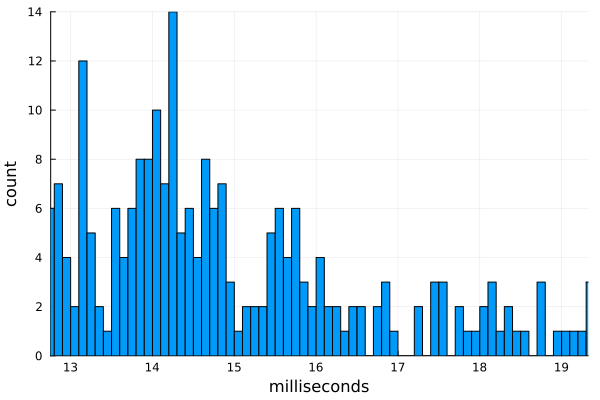

In [27]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [30]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [31]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 504 samples with 1 evaluation.
 Range (min … max):  7.440 ms … 39.142 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.942 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.897 ms ±  2.992 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

   █▁                                                         
  ███▆▇▆█▇▃▅▄▄▃▄▄▄▃▃▃▃▃▃▄▃▃▃▃▃▃▂▂▁▂▂▂▁▂▁▁▂▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▂ ▃
  7.44 ms        Histogram: frequency by time        20.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [32]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

7.440143

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [33]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
  No Changes to `~/Documents/GitHub/Introduction-to-Julia/Project.toml`
  No Changes to `~/Documents/GitHub/Introduction-to-Julia/Manifest.toml`


In [35]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [36]:
pysum(a)

5.000917596566406e6

In [37]:
pysum(a) ≈ sum(a)

true

In [38]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.728 s …    2.002 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.759 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.830 s ± 149.946 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █     █                                                  █  
  █▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.73 s         Histogram: frequency by time            2 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [28]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.38288
  "Python built-in" => 875.812
  "C -ffast-math"   => 1.78121

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [39]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/Documents/GitHub/Introduction-to-Julia/Project.toml`
  No Changes to `~/Documents/GitHub/Introduction-to-Julia/Manifest.toml`


In [40]:
Conda.add("numpy")

[ Info: Downloading miniconda installer ...
[ Info: Installing miniconda ...


PREFIX=/home/nadidela/.julia/conda/3/x86_64
Unpacking payload ...
Extracting _libgcc_mutex-0.1-conda_forge.tar.bz2
Extracting ca-certificates-2023.7.22-hbcca054_0.conda
Extracting ld_impl_linux-64-2.40-h41732ed_0.conda
Extracting libstdcxx-ng-13.1.0-hfd8a6a1_0.conda
Extracting pybind11-abi-4-hd8ed1ab_3.tar.bz2
Extracting python_abi-3.10-3_cp310.conda
Extracting tzdata-2023c-h71feb2d_0.conda
Extracting libgomp-13.1.0-he5830b7_0.conda
Extracting _openmp_mutex-4.5-2_gnu.tar.bz2
Extracting libgcc-ng-13.1.0-he5830b7_0.conda
Extracting bzip2-1.0.8-h7f98852_4.tar.bz2
Extracting c-ares-1.19.1-hd590300_0.conda
Extracting fmt-9.1.0-h924138e_0.tar.bz2
Extracting icu-73.2-h59595ed_0.conda
Extracting keyutils-1.6.1-h166bdaf_0.tar.bz2
Extracting libev-4.33-h516909a_1.tar.bz2
Extracting libffi-3.4.2-h7f98852_5.tar.bz2
Extracting libiconv-1.17-h166bdaf_0.tar.bz2
Extracting libnsl-2.0.0-h7f98852_0.tar.bz2
Extracting libuuid-2.38.1-h0b41bf4_0.conda
Extracting libzlib-1.2.13-hd590300_5.conda
Extracting l

[ Info: Running `conda install -y numpy` in root environment


Solving environment: ...working... done




==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.9.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.9.0





## Package Plan ##

  environment location: /home/nadidela/.julia/conda/3/x86_64

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libblas-3.9.0              |19_linux64_openblas          14 KB  conda-forge
    libcblas-3.9.0             |19_linux64_openblas          14 KB  conda-forge
    libgfortran-ng-13.2.0      |       h69a702a_0          23 KB  conda-forge
    libgfortran5-13.2.0        |       ha4646dd_0         1.4 MB  conda-forge
    liblapack-3.9.0            |19_linux64_openblas          14 KB  conda-forge
    libopenblas-0.3.24         |pthreads_h413a1c8_0         5.2 MB  conda-forge
    numpy-1.26.0               |  py310hb13e2d6_0         6.6 MB  conda-forge
    openssl-3.1.3              |       hd590300_0         2.5 MB  conda-forge
    ------------------------------------------------------------
                                     

In [41]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 500 samples with 1 evaluation.
 Range (min … max):  7.175 ms … 30.817 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.106 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.970 ms ±  2.814 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆█▆▂ ▁▁▁▁                                                   
  █████████▆▅▆▆▅▆▆▇▆▇▆▆▅▆▄▅▄▄▃▄▃▄▃▁▃▄▃▃▂▁▁▂▃▂▂▁▂▁▂▁▃▁▁▂▁▁▂▂▂ ▄
  7.17 ms        Histogram: frequency by time        19.6 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [42]:
numpy_sum(a)

5.00091759656628e6

In [43]:
numpy_sum(a) ≈ sum(a)

true

In [44]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"             => 12.7661
  "Python numpy"  => 7.1746
  "C -ffast-math" => 7.44014

# 5. Python, hand-written 

In [46]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fa7d6cabf60>

In [47]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.542 s …   2.593 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.567 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.567 s ± 36.112 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.54 s         Histogram: frequency by time        2.59 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [48]:
sum_py(a)

5.000917596566406e6

In [49]:
sum_py(a) ≈ sum(a)

true

In [50]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"                   => 12.7661
  "Python numpy"        => 7.1746
  "Python hand-written" => 2541.69
  "C -ffast-math"       => 7.44014

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [51]:
@which sum(a)

sum(a::AbstractArray; dims, kw...)
     @ Base reducedim.jl:994

In [52]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 478 samples with 1 evaluation.
 Range (min … max):   7.448 ms … 48.914 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      8.937 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.413 ms ±  4.434 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▆▆▆▄▅▃▁▂▃▂▃▁▁                                               
  █████████████████▆█▆▆▁█▆▅▄▆▄▅▄▅▄▅▄▁▁▁▁▄▁▄▁▁▁▅▅▅▄▁▄▁▄▁▁▄▁▁▁▄ ▇
  7.45 ms      Histogram: log(frequency) by time      28.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [53]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 12.7661
  "Python numpy"        => 7.1746
  "Python hand-written" => 2541.69
  "Julia built-in"      => 7.44824
  "C -ffast-math"       => 7.44014

# 7. Julia (hand-written) 

In [54]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [55]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 300 samples with 1 evaluation.
 Range (min … max):  12.998 ms … 56.195 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.380 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.632 ms ±  4.260 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▆█▇▅▁▄   ▁   ▂                                               
  ██████▇▇▄█▆▇██▆▇▆▄▄▄▅▃▅▄▃▄▁▁▃▄▃▁▃▃▄▁▃▃▁▃▃▃▄▁▃▃▃▁▃▁▁▁▁▃▁▁▁▁▃ ▄
  13 ms           Histogram: frequency by time        30.5 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [56]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 12.7661
  "Python numpy"        => 7.1746
  "Julia hand-written"  => 12.9983
  "Python hand-written" => 2541.69
  "Julia built-in"      => 7.44824
  "C -ffast-math"       => 7.44014

# 8. Julia (hand-written w. simd) 

In [57]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [58]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 510 samples with 1 evaluation.
 Range (min … max):  6.999 ms … 23.451 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     8.681 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.765 ms ±  2.959 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █▅▁▄                                                        
  █████▇▇▆▅▆▅▄▃▄▄▄▃▅▅▅▄▄▄▄▃▃▃▃▂▃▂▃▃▃▃▂▁▃▂▂▁▁▂▁▂▁▂▂▁▁▂▁▂▁▁▂▁▂ ▃
  7 ms           Histogram: frequency by time        21.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [59]:
mysum_simd(a)

5.000917596566439e6

In [60]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "Julia hand-written simd" => 6.99913
  "C"                       => 12.7661
  "Python numpy"            => 7.1746
  "Julia hand-written"      => 12.9983
  "Python hand-written"     => 2541.69
  "Julia built-in"          => 7.44824
  "C -ffast-math"           => 7.44014

# Summary

In [61]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Julia hand-written simd.....7.0
Python numpy................7.2
C -ffast-math...............7.4
Julia built-in..............7.4
C..........................12.8
Julia hand-written.........13.0
Python hand-written......2541.7
